Motivated from Pieter Abeel Course Unsupervised Deep Learning at UC Berkely

In [ ]:
# p(x_i | x_{i-1}, x_{i-2},...,x_1)
# I[i,j] (i,j) \in{1,2,...,28}, I[i,j] \in {0,1}
# x_inp = vecotr of size 28*28

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


#PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models,transforms
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
%matplotlib inline



In [ ]:
device = torch.device('cuda')
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
input_shape = (1,14,14)

In [ ]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.Resize((input_shape[1],input_shape[2])),
                        transforms.ToTensor(),
                    ])

    transform_valid = transforms.Compose([
                        transforms.Resize((input_shape[1],input_shape[2])),
                        transforms.ToTensor(),
                    ])

    transform_test = transforms.Compose([
                        transforms.Resize((input_shape[1],input_shape[2])),
                        transforms.ToTensor(),
                    ])


    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler,pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader


In [ ]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, valid_loader, test_loader=mnist(batch_sz)

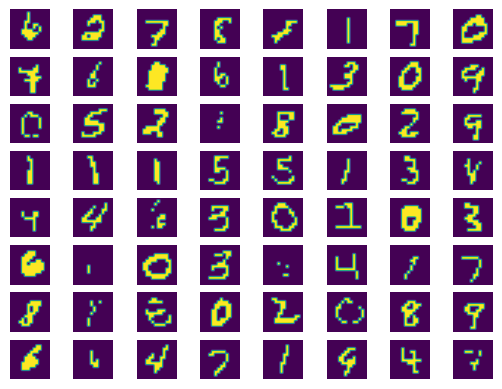

In [ ]:
batch = next(iter(train_loader))
X = 1.0*(batch[0]>0.5)
for i in range(X.shape[0]):
  plt.subplot(8,8,i+1)
  plt.imshow(X[i,0,:,:])
  plt.axis("off")

In [ ]:
from torchvision.utils import make_grid
def append_location_mine(x, device):
    idxs = torch.arange(input_shape[1]).float() / (input_shape[1]-1)  # Scale to [0, 1]
    locs = torch.stack(torch.meshgrid(idxs, idxs), dim=-1)
    locs = locs.permute(2, 0, 1).contiguous().unsqueeze(0).repeat(x.shape[0], 1, 1, 1)
    locs = locs.to(device)

    x = torch.cat((x, locs), dim=1)
    return x

def visualize_batch(batch_tensor, nrow=8, title='', figsize=None):
    grid_img = make_grid(batch_tensor, nrow=nrow)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


In [ ]:
# X =(x1, x2,----, xN)
# X ~ p(X)
# p(X) = p(x1)* p(x2|x1)* p(x3|x2,x1)*....* p(x_{N-1}|x_{N-2},...,x1)* p(x_N|x_{N-1},...,x1)
# x1 ~ p(x1)
# x2 ~ p(x2| x1)
# x3 ~ p(x3| x2, x1)
#
#
# xN ~ p(xN| x_{N-1}, ---, x_1)

# y = f(x)
# p(x)dx = p(y) dy

# p(x2) p(x3) p(x4)     p(xt)
# h1--->h2--->h3--------ht
# x1.   x2.   x3.       xt

In [ ]:
# I ---> x_inp [x_{above_neighbor},----28----x_pixel, -----28> x_{bottom neighbr}]
# x =(x_1, p_x_1, p_y_1), (x_2 , p_x_2, p_y_2), ....,(x_N, p_x_N, p_y_N)

# I[i,j] --->append_loc---> I[i,j,1] = I[i,j] , I[i,j,1] = p_x, I[i,j,2] = p_y

# h_t = sigmoid(W_h @ h_{t-1} + W_x @ X_t)
# W_h ----> (256, 256)
# W_x ----> (256, 28*28)

# P(x_t|x_{t-1}<)y_t = sigmoid(W_y * h_t)

# p(x2|x1) --->(0,1)


 #(x1, x2, ..., xN)--->RNN--->(p(x1=1)=p(x1), p(x2|.), p(x3|.)...p(xN|.))
 #test time
 # sample x1---> get p(x2|.)
 # sampel x2 ----> get p(x3|)
# sample x3---> get p(x4|.)
 # sampel x4 ----> get p(x5|)
 # .
 # .
 # .
# sample x_{N-2}---> get p(x_{N-1}|.)
 # sampel X_{X-1} ----> get p(x_N|) ---> sample x_N


In [ ]:
class RNN_Example(nn.Module):

    def __init__(self, device, append_loc=False, input_shape=input_shape, hidden_size=256):
        super().__init__()
        self.device = device
        self.append_loc = append_loc
        self.input_channels = input_shape[0] + 2 if append_loc else input_shape[0]
        self.hidden_size = hidden_size
        self.input_shape = input_shape
        self.canvas_size = input_shape[1] * input_shape[2]

        self.rnn = nn.RNN(self.input_channels, self.hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, input_shape[0])

    def nll(self, x):
        batch_size = x.shape[0]
        x_inp = append_location_mine(x, self.device) if self.append_loc else x
        # Shift input by one to the right
        x_inp = x_inp.permute(0, 2, 3, 1).contiguous().view(batch_size, self.canvas_size, self.input_channels)
        x_inp = torch.cat((torch.zeros(batch_size, 1, self.input_channels).to(self.device), x_inp[:, :-1]), dim=1)
        h0 = torch.zeros(1, x_inp.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(1, x_inp.size(0), self.hidden_size).to(self.device)
        # Forward propagate LSTM
        out, _ = self.rnn(x_inp, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # Decode the hidden state of the last time step
        out = self.fc(out).squeeze(-1) # b x 784
        return F.binary_cross_entropy_with_logits(out, x.view(batch_size, -1))


    def sample(self, n):
        with torch.no_grad():
            samples = torch.zeros(n, 1, self.input_channels).to(self.device)
            h = torch.zeros(1, n, self.hidden_size).to(self.device)
            c = torch.zeros(1, n, self.hidden_size).to(self.device)

            for i in range(self.canvas_size):
              #time 0 -->[(0,0,0)_0,(1,0,0)_1,(0,0.2,0)_2,.....(1,0,0)_n]
                x_inp = samples[:, [i]]
                out, h = self.rnn(x_inp, h)
                out = self.fc(out[:, 0, :])
                prob = torch.sigmoid(out)
                sample_pixel = torch.bernoulli(prob).unsqueeze(-1) # n x 1 x 1
                if self.append_loc:
                    loc = np.array([i // input_shape[1], i % input_shape[1]]) / (input_shape[1]-1)
                    loc = torch.FloatTensor(loc).to(self.device)
                    loc = loc.view(1, 1, 2).repeat(n, 1, 1)
                    sample_pixel = torch.cat((sample_pixel, loc), dim=-1)
                samples = torch.cat((samples, sample_pixel), dim=1)

            if self.append_loc:
                samples = samples[:, 1:, 0] # only get sampled pixels, ignore location
            else:
                samples = samples[:, 1:].squeeze(-1) # n x 784
            samples = samples.view(n, *self.input_shape)
            return samples.cpu()


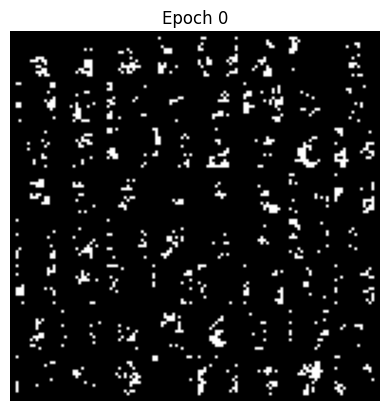

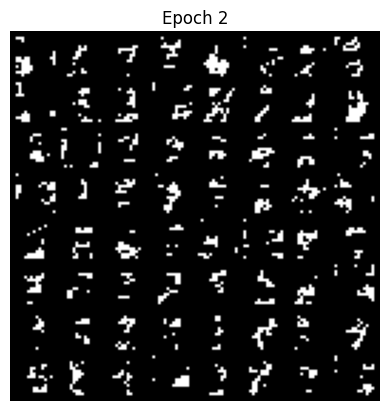

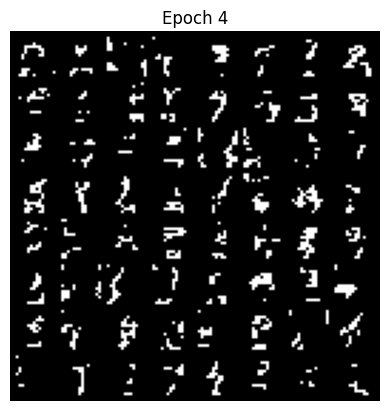

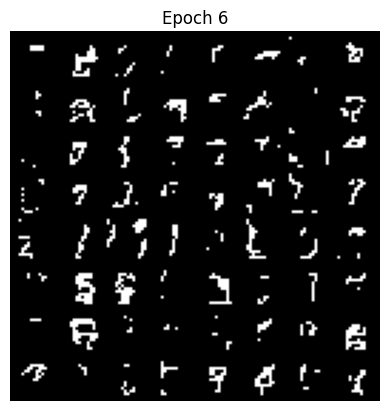

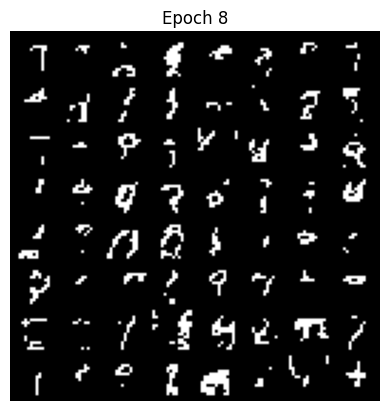

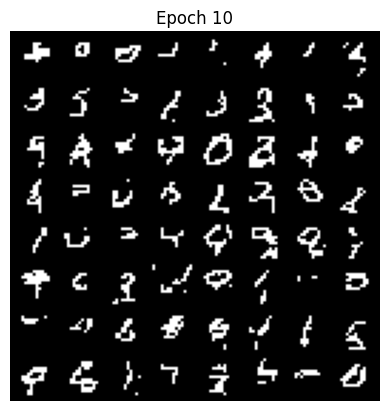

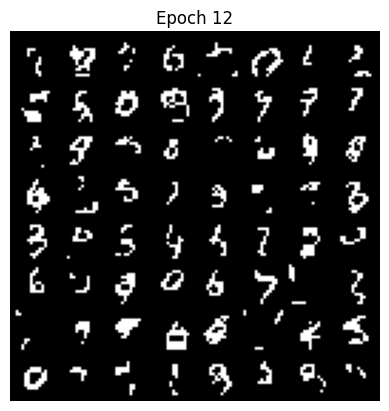

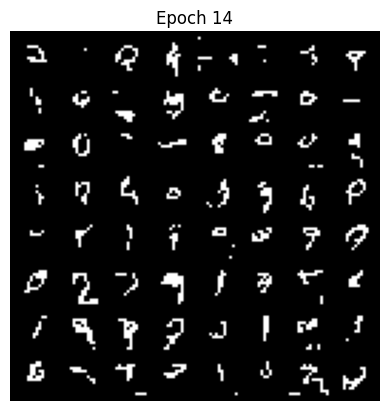

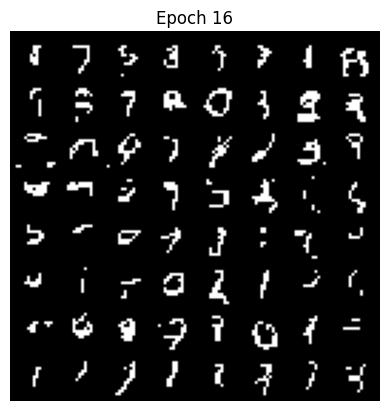

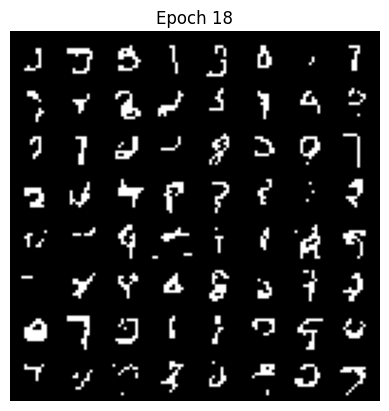

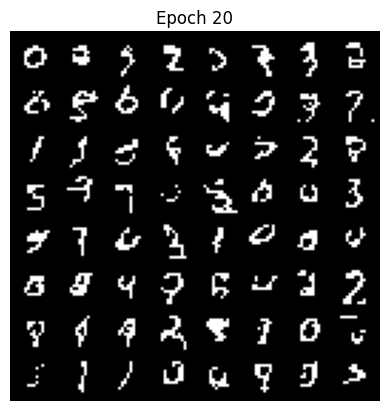

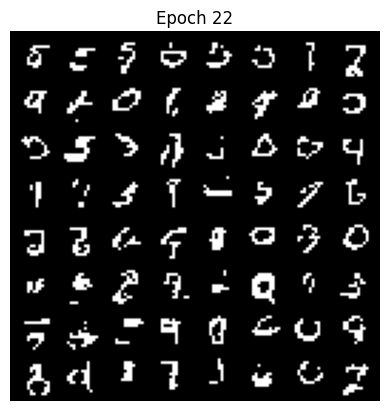

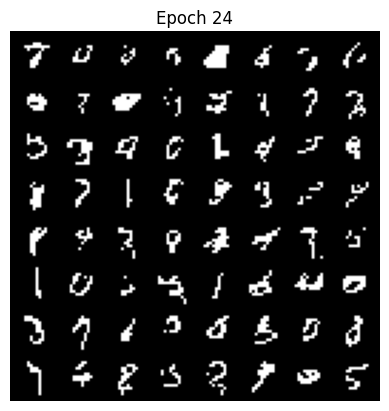

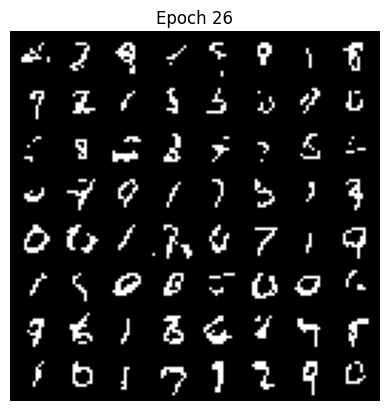

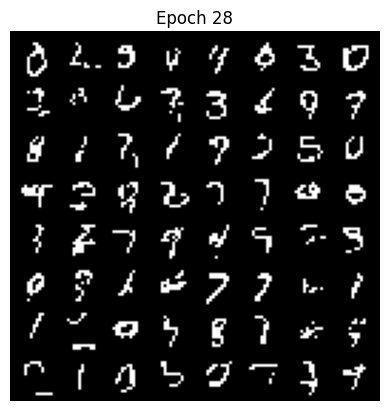

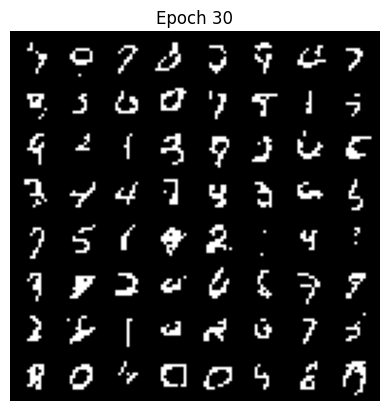

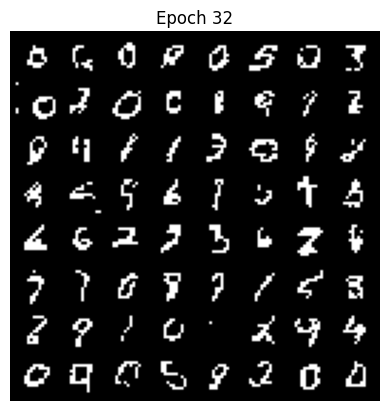

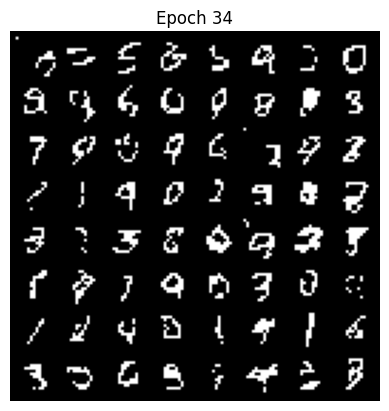

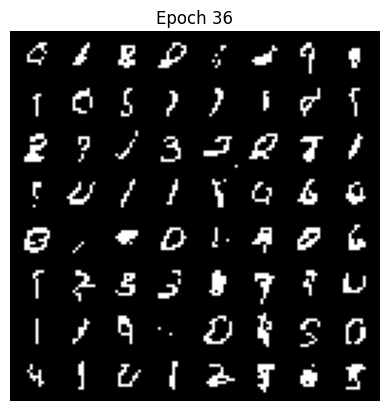

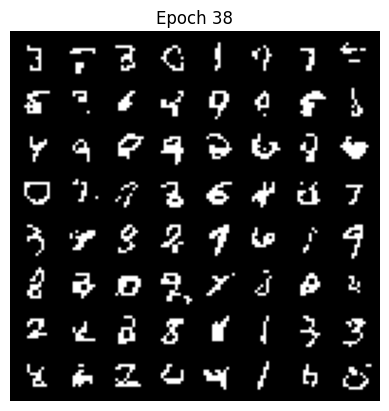

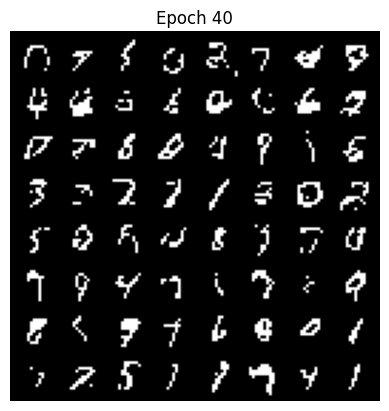

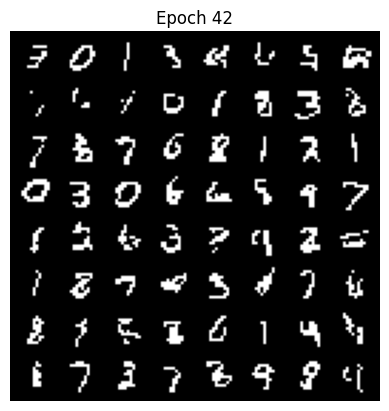

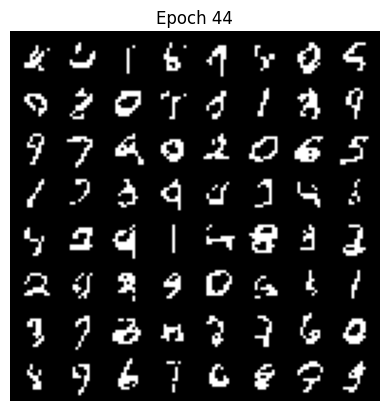

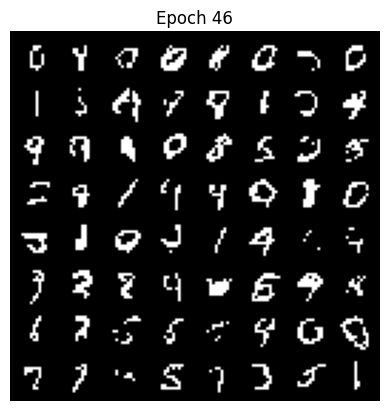

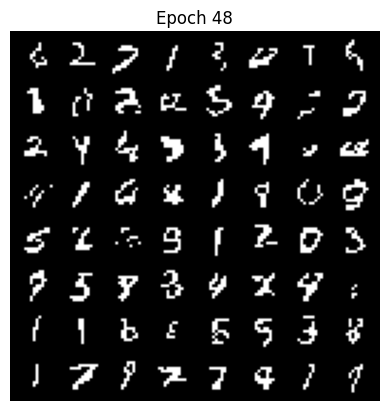

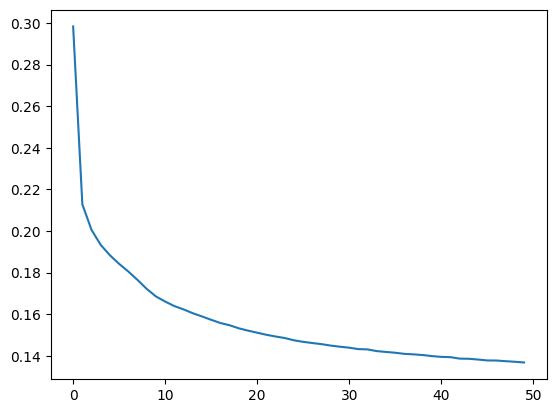

In [ ]:
device = torch.device("cuda:0")
net = RNN_Example(device, append_loc=False).to(device)
net.train()
epochs, lr = 50, 2e-4
optimizer = optim.Adam(net.parameters(), lr=lr)

ls = []
for epoch in range(epochs):

  train_losses = []
  for x in train_loader:
    x = 1.0*(x[0]>0.5).to(device)
    loss = net.nll(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
  if epoch%2==0:
    samples = net.sample(64)
    visualize_batch(samples, title=f'Epoch {epoch}')
  ls.append(np.mean(train_losses))

plt.plot(ls)